In [1]:
### Author: Calvin Nguyen
### Date: 11/7/2020 2:30am
### Purpose: Simulate trading plans

# Features:
# Monthly Report (specified and month and default is current month) -- done
# Monte Carlo
# Optimize stop loss 
# train, validation, test split dataset
# __add__ to add strategy systems                                   -- done
# moving averages for specified features 
# profit graph growth %
# add commas between numbers


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt
from dateutil.relativedelta import relativedelta

In [249]:
class Simulation:
    def __init__(self, dataframe, startingBalance=3000, risk=0.20, borrows=0.08):
        self.dataframe = dataframe.copy()
        self.startingBalance = startingBalance
        self.balance = startingBalance
        self.risk = risk
        self.borrows = borrows
        
        
    def _filterConditions(self, dataframe):
        """Filter the dataframe based on given conditions."""
        conditionLst = []  ### USER INPUT ### 'PM_Vol_Float > 2'

        while True:
            ans = input("Specify a FILTER condition (Press Q when no more conditions): ")
            if ans.upper() == 'Q':
                print()
                break
            conditionLst.append(ans)

        if conditionLst:
            for condition in conditionLst:
                dataframe = dataframe.query(condition).reset_index().drop("index", axis=1)

        return dataframe
    
    
    def _entryConditions(self):
        """Enter position only if all conditions are met."""
        entry_dict = {}
        conditionLst = ['trade["Open"] == trade["Open"]']  ### USER INPUT

#         while True:
#             criteria = input("Specify an ENTRY condition (Press Q when no more conditions): ")
#             if criteria.upper() == 'Q':
#                 print()
#                 break
#             conditionLst.append(criteria)
#         action = input("Specify an action [Entry Price]: ")

        action =  'trade["Open"]'### USER INPUT
        
        entry_dict["conditions"] = conditionLst
        entry_dict["action"] = action
        
        return entry_dict
    
    
    def _stoplossConditions(self):
        """Exit position when a condition is met."""
        stoploss_dict = {}
        conditionLst = ['trade["High"] > (trade["Open"] * 1.40)']  ### USER INPUT

#         while True:
#             criteria = input("Specify an STOP LOSS condition (Press Q when no more conditions): ")
#             if criteria.upper() == 'Q':
#                 print()
#                 break
#             conditionLst.append(criteria)
#         action = input("Specify an action [Exit Price]: ")

        action = 'trade["Open"] * 1.37'  ### USER INPUT
            
        stoploss_dict["conditions"] = conditionLst
        stoploss_dict["action"] = action
        
        return stoploss_dict
    
    def _takeprofitConditions(self):
        """Exit position when a condition is met."""
        takeprofit_dict = {}
        conditionLst = ['trade["Close"] == trade["Close"]']  ### USER INPUT

#         while True:
#             criteria = input("Specify a TAKE PROFIT condition (Press Q when no more conditions): ")
#             if criteria.upper() == 'Q':
#                 print()
#                 break
#             conditionLst.append(criteria)
#         action = input("Specify an action [Exit Price]: ")

        action = 'trade["Close"]'  ### USER INPUT
        
        takeprofit_dict["conditions"] = conditionLst
        takeprofit_dict["action"] = action
 
        return takeprofit_dict

    def _check_entry(self, trade, entry_plan):
        """Check to see if trade meets entry conditions."""
        conditions = entry_plan["conditions"]
        
        for condition in conditions:
            if not eval(condition):
                return 
            
        return eval(entry_plan["action"])
            
    def _check_exit(self, trade, stoploss_plan, takeprofit_plan):
        """Check to see if condition is met and take the required actions."""
        stoploss_conditions = stoploss_plan["conditions"]
        for condition in stoploss_conditions:
            if eval(condition):
                return (eval(stoploss_plan["action"]), eval(stoploss_plan["action"]))
        
        takeprofit_conditions = takeprofit_plan["conditions"]
        for condition in takeprofit_conditions:
            if eval(condition):
                return (eval(stoploss_plan["action"]), eval(takeprofit_plan["action"]))
            
        raise ValueError("Simulation._check_exit Exit condition never got hit.")
    
    
    def createPlan(self):
        """Filter trades, create a entry plan, a stop loss plan, and take profit plan."""
        self.filtered_dataframe = self._filterConditions(self.dataframe)
        self.entry_plan = self._entryConditions()
        self.stoploss_plan = self._stoplossConditions()
        self.takeprofit_plan = self._takeprofitConditions()
        
    
    def executePlan(self, dataframe=None):
        """Trade the created plan on the given dataset."""
        self.balance = self.startingBalance
        percentage_lst = []
        profit_graph = []
        
        if dataframe is None:
            dataframe = self.filtered_dataframe
        
        for rowNum in range(len(dataframe)):
            # select trade
            trade = dataframe.iloc[rowNum]
            
            # decide if you take an entry
            entry = self._check_entry(trade, self.entry_plan)
            
            # if not entered, then move on to next trade
            if entry is None:
                continue
                
            # compute the trade result
            while True:
                try:
                    stoploss, trade_result = self._check_exit(trade, self.stoploss_plan, self.takeprofit_plan)
                except ValueError as e:
                    print(e)
                    self.exit_plan = self._exitConditions()
                else:
                    break
            
            # calculating size
            dollar_risk = self.balance * self.risk
            shares = dollar_risk / (stoploss - entry)
            
            borrow_fees = shares * self.borrows
            position = shares * entry
            
            # calculating end of day profit and balance
            percentage_profit = (entry - trade_result) / entry
            eod_result = (position * percentage_profit) - borrow_fees
            self.balance += eod_result
            
            percentage_lst.append(percentage_profit)
            profit_graph.append(self.balance)
            
        self._strategy_statistics(profit_graph, percentage_lst)
        
    def _strategy_statistics(self, profit_graph, percentage_lst):
        """Visualize trade results and print out strategy statistics."""
        # plot line chart of account growth
        plt.figure(figsize=(12, 3))
        plt.subplot(121)
        plt.plot(profit_graph)
        plt.title("Profit Chart")

        # plot bar chart the gain % 
        plt.subplot(122)
        for index, value in enumerate(percentage_lst):
            if value <= 0:
                plt.bar(index, value, color='r')
            else:
                plt.bar(index, value, color='g')
        plt.title("Gain % Chart")

        plt.show()

        # strategy statistics
        print("Final Account:   ", round(profit_graph[-1], 2))
        print("Growth:          ", round((self.balance - self.startingBalance) / self.startingBalance * 100, 2), "%")
        print("Win Rate:        ", round(sum(1 for percentage in percentage_lst if percentage > 0) / len(percentage_lst) * 100, 2), "%")
        print("Risk Reward:     ", round(np.average(np.array([percentage for percentage in percentage_lst if percentage > 0])) /
                              abs(np.average(np.array([percentage for percentage in percentage_lst if percentage <= 0]))), 2))
        print("Sample Size:     ", len(percentage_lst))
        print("Growth Per Trade:", round(((self.balance - self.startingBalance) / (self.startingBalance) * 100) / len(percentage_lst), 2), "%")

        
    def monthly_report(self, month_year=str(dt.datetime.today().month) + '/' + str(dt.datetime.today().year)):
        """Print monthly review of strategy."""
        month_df = self.filtered_dataframe[(self.filtered_dataframe['Date'] >= pd.to_datetime(month_year)) & 
                                           (self.filtered_dataframe['Date'] < (pd.to_datetime(month_year)
                                                                               + relativedelta(months=1)))]
        if month_df.empty:
            raise ValueError("Simulation.monthly_report Dataframe is empty!!!")
        
        self.executePlan(month_df)
        
        
    def yearly_report(self, year=str(dt.datetime.today().year)):
        """Print yearly review of strategy."""
        year_df = self.filtered_dataframe[(self.filtered_dataframe['Date'] >= pd.to_datetime(year)) & 
                                          (self.filtered_dataframe['Date'] < (pd.to_datetime(year)
                                                                               + relativedelta(years=1)))]
        
        if year_df.empty:
            raise ValueError("Simulation.yearly_report Dataframe is empty!!!")
        
        self.executePlan(year_df)            
        
    def optimize_risk(self):
        pass
    
    def monteCarlo(self):
        pass
    
    def __add__(self, right):
        """Combine two strategy profits together."""
        if right is not Simulation:
            raise TypeError("Simulation.__add__ right({}) must be a Simulation object".format(right))
            
        return self.balance + right.balance
    
        

In [492]:
df = pd.read_csv('./Gap Up 60%+/Data/Merged Database - Copy of Gappers.csv')
df = df[(df['PM_Vol'] >= 0.750) &
        (df['Market Cap (Open)'] < 400) & 
        (df['Float'] < 30) & 
        (df['Open Distance from PM High'] < 0.7)]

In [493]:
for column in df.columns:
    print(column)

Date
Ticker
Set_Up
Picture
Sector
Industry
Index
RS_Date
Outstanding_Shares
Float
Institutional_Ownership
Short_Float
Insider_Ownership
Max_Resistance
Max_Resistance_Vol
Max_Resistance_High
Max_Resistance_Low
Max_Resistance_VWAP
Max_Resistance_Morning_Vol
Recent_Resistance
Recent_Resistance_Vol
Recent_Resistance_High
Recent_Resistance_Low
Recent_Resistance_VWAP
Recent_Resistance_Morning_Vol
Resistance_Num
Combined_Resistance_Vol
SSR
Prev_Close
PM_High
PM_Low_After_PM_Top
Open
High_Before_Day_Low
High_Before_Day_Low_Time
Day_Low
Day_Low_Time
Vol_to_Top_Tick
High
High_Time
15_Min_High_Vol
Intraday_Range_50
Intraday_Range_50_Time
PM_Range_50
PM_Range_50_Time
Low_After_Top
Low_After_Top_Time
Close
Daily_VWAP
PM_Vol
Vol_9:30_9:32
Vol_9:32_9:35
Vol_9:35_9:40
Vol_9:40_9:45
Vol_9:45_10:00
Vol_10:00_10:30
Vol_10:30_11:00
Vol_11:00_11:30
Vol_11:30_12:00
Vol_12:00_12:30
Vol_12:30_13:00
Vol_13:00_13:30
Vol_13:30_14:00
Vol_14:00_14:30
Vol_14:30_15:00
Vol_15:00_15:30
Vol_15:30_16:00
Volume
Day Run
H

In [494]:
tidy_df = df[['Date', 'Open', 'High', 'Close', 'PM_Vol', 'PM Vol / Float']]

In [495]:
# tidy_df.columns = ['_'.join(column.split()) if ' ' in column else column for column in tidy_df.columns]
tidy_df.columns = ['Date', 'Open', 'High', 'Close', 'PM_Vol', 'PM_Vol_Float']
        

In [496]:
tidy_df['Date'] = tidy_df['Date'].map(lambda x: pd.to_datetime(x))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [501]:
gappers = Simulation(tidy_df, risk=0.20)

In [502]:
gappers.createPlan()

Specify a FILTER condition (Press Q when no more conditions): Q



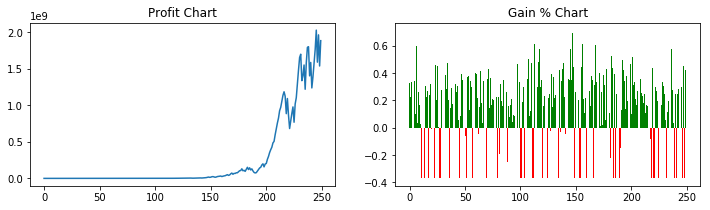

Final Account:    1883129308.19
Growth:           62770876.94 %
Win Rate:         76.4 %
Risk Reward:      0.91
Sample Size:      250
Growth Per Trade: 251083.51 %


In [503]:
gappers.executePlan()

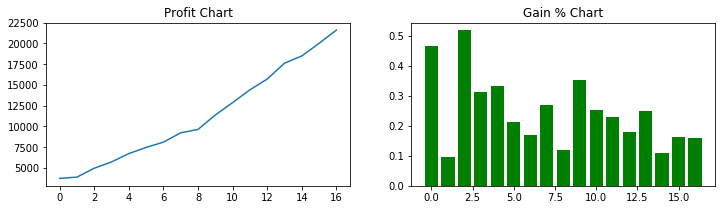

Final Account:    21597.79
Growth:           619.93 %
Win Rate:         100.0 %
Risk Reward:      nan
Sample Size:      17
Growth Per Trade: 36.47 %


In [509]:
gappers.monthly_report('8/2020')

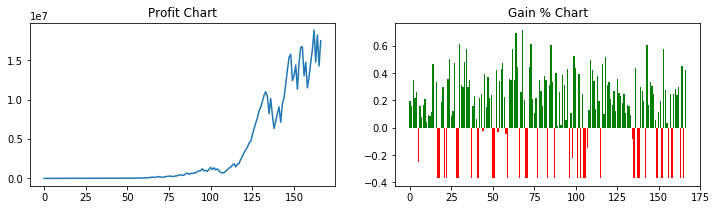

Final Account:    17468471.97
Growth:           582182.4 %
Win Rate:         75.45 %
Risk Reward:      0.92
Sample Size:      167
Growth Per Trade: 3486.12 %


In [507]:
gappers.yearly_report('2020')

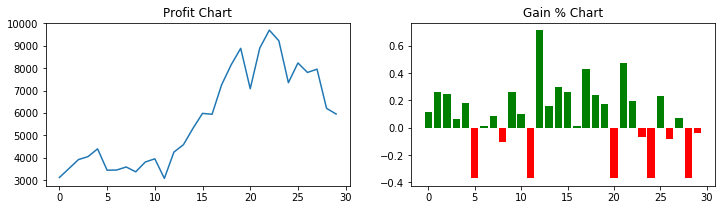

Final Account:  5955.41
Growth:         98.51 %
Win Rate:       70.0 %
Risk Reward:    0.92
Sample Size:    30


In [27]:
gappers.yearly_report()